In [1]:
############
# https://stackoverflow.com/questions/69800749/using-python-to-get-holdings-and-allocation-of-etfs
# conda env create -f environment.yml
# conda install -f environment.yml
# conda update -n base conda
# conda env update --file environment.yml --prune
# print("https://www.etfdb.com")
print("https://www.etfrc.com/funds/overlap.php")
TRADITIONAL = 'VYM VOT MGK VIG VGT VOO VDE VCR VHT VFH VUG'
# "AIRR CLSE CRPT HTUS IGM KBWP MGK PAVE PKB RSHO SLX SPSM VCR VDE VFH VGT VHT VIG VOO VOT VUG VYM XBI XHB"
ROTH = 'SPYG SCHG QQQ VGT CRPT IGM PAVE PKB XHB' # Roth 2024.03.14. 04.01 -IVW VOO MGK VTI IUSG VUG

BASE = 'VOT VOO VTI FLMVX FXAIX'
CONSTRUCTION = 'AIRR PKB XHB ITB'
GROWTH = 'MGK VGT VUG QQQ IVW SCHG SPYG IUSG FCNKX JDMNX MITJX VIGIX'
DIV = 'VYM VIG'
ENERGY = 'AMZA URNM VDE'
INSURANCE = 'KBWP'
SECTORS = 'VOX VCR VDC VFH VHT VIS VAW VPU RSHO PRN'
INTERNATIONALS = 'VEU VSS VEA VWO VGK VPL VNQI VXUS VT'
CRYPTO = 'CRPT'# DAPP BITQ BKCH SATO WGMI IBLC # BITX (2023-06-27) GBTC IBIT (2024-1-11)
INFRA = 'PAVE'# IGF IFRA NFRA EMIF RBLD
AI = 'IGM IYW FTEC FDN'

BENCH = 'VOO CRPT SPSM '# KBWP PAVE IGM VGT QMOM URNM AMZA PKB=XHB SLX
TEST = BENCH + " BTC-USD ETH-USD"
TEST = BENCH + 'CLSE XBI IAI KCE PSP XMMO XSMO UTES HTUS' # HRTS CBLS USE GCAD SLX VDE
start = '2020-11-03'

https://www.etfrc.com/funds/overlap.php


In [2]:
# Import libraries and pull data
import datetime
import warnings
import re
import json
import textwrap
import numpy as np
import pandas as pd
# import pandas_ta as ta
import yfinance as yf
#import quantstats as qs
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import widgets, interact, interactive
from scipy import stats
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from keras.models import Sequential
#from keras.layers import Dense, LSTM, Activation
from IPython.display import display, clear_output, HTML
from yahooquery import Ticker, Screener
from pyvis import network as net
import networkx as nx

cf.go_offline()
pio.renderers.default = 'iframe'
plt.style.use('dark_background')
warnings.filterwarnings("ignore", category=FutureWarning, module="yfinance")
warnings.filterwarnings("ignore", category=FutureWarning, module="cufflinks")
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "warn_singular")
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
template = 'plotly_dark'
pd.options.display.float_format = "{:,.2f}".format

# EPOCH=64
# EPOCH=32
NOP = 20000 # Number of random portfolio sets
risk_free_return = .05
rwindow = 6 # How many trading days to aggregate MACD/ RSI for
cutoff = 20 # % of samples falling below that satisfy criteria for MACD/ RSI
model = 'Sharpe'
categories = {
    "ai": AI,
    "base": BASE,
    "construction": CONSTRUCTION,
    "crypto": CRYPTO,
    "div": DIV,
    "energy": ENERGY,
    "growth": GROWTH,
    "infra": INFRA,
    "insurance": INSURANCE,
    "internationals": INTERNATIONALS,
    "sectors": SECTORS,
}

In [3]:
def rsi_target(df1, prc=25):
    df = df1.copy()
    pt={v:0 for v in df['Adj Close'].columns}
    while 0 in pt.values():
        df.loc[df['Adj Close'].index[-1], 'Adj Close', ] =  df.iloc[-1].loc['Adj Close'].values * .99
        cv = calculate_rsi(df).tail(1)
        for v in cv:
            if bool(pt[v]):
                continue
            tv = df.iloc[-1]['Adj Close', v].round(2)
            pt[v] = pt[v] if cv[v].iloc[-1] > prc else float(tv)
    return pt

def compare_values_ichi(row):
    # TODO: distinguish between green and red
    if row['Close'] > max([row['senkou_span_a'], row['senkou_span_b']]):
        if row['senkou_span_a'] > row['senkou_span_b']:
            return 'top left'
        elif row['senkou_span_a'] < row['senkou_span_b']:
            return 'top right'
        return 'top center'
    elif row['Close'] < min([row['senkou_span_a'], row['senkou_span_b']]):
        if row['senkou_span_a'] < row['senkou_span_b']:
            return 'bottom left'
        elif row['senkou_span_a'] > row['senkou_span_b']:
            return 'bottom right'
        return 'bottom center'
    else:
        return 'middle center'

def calc_positions_ichimoku(d):
    global idx
    columns = d['Low'].columns
    # Adding signals for buy/ sell
    condition = np.where(
        (d['tenkan_sen'] > d['kijun_sen']) &
        (d['Close'] > d['tenkan_sen']) &
        (
            ((d['Close'] > d['senkou_span_a']) & (d['Close'] > d['senkou_span_b'])) |
            ((d['Close'] < d['senkou_span_a']) & (d['Close'] < d['senkou_span_b']))
        ), 1, 0
    )
    sgn = pd.DataFrame(condition, columns=columns, index=d.index)
    sgn.columns = pd.MultiIndex.from_product([['signal_ichimoku'], columns])
    pos = sgn.diff().fillna(0)
    pos.columns = pd.MultiIndex.from_product([['position_ichimoku'], columns])
    idx.drop(columns='signal_ichimoku', inplace=True, errors='ignore')
    idx.drop(columns='position_ichimoku', inplace=True, errors='ignore')
    idx = idx.join(pos)
    idx = idx.join(sgn)

def calc_positions_rsi(d):
    global idx
    columns = d['Low'].columns
    # Adding signals for buy/ sell
    indicator='RSI'
    period=42
    sgn = pd.DataFrame(np.where(d[indicator].rolling(window=period).mean() - idx[indicator] - .3 < 0, 0, 1), columns=columns, index=d.index)
    sgn.columns = pd.MultiIndex.from_product([['signal_rsi'], columns])
    pos = sgn.diff().fillna(0)
    pos.columns = pd.MultiIndex.from_product([['position_rsi'], columns])
    idx.drop(columns='signal_rsi', inplace=True, errors='ignore')
    idx.drop(columns='position_rsi', inplace=True, errors='ignore')
    idx = idx.join(pos)
    idx = idx.join(sgn)
    
def calc_positions_ema(d):
    global idx
    columns = d['Low'].columns
    # Adding signals for buy/ sell
    sgn = pd.DataFrame(np.where(d['EMAW'] > d['EMAM'], 1, 0), columns=columns, index=d.index)
    sgn.columns = pd.MultiIndex.from_product([['signal_ema'], columns])
    pos = sgn.diff().fillna(0)
    pos.columns = pd.MultiIndex.from_product([['position_ema'], columns])
    idx.drop(columns='signal_ema', inplace=True, errors='ignore')
    idx.drop(columns='position_ema', inplace=True, errors='ignore')
    idx = idx.join(pos)
    idx = idx.join(sgn)

def price_bands(period = 42, multiplier = 1.8): # Calculate price bands
    global idx
    
    columns = idx['Low'].columns
    
    std = idx['Adj Close'].rolling(window=period).std()
    std.columns = pd.MultiIndex.from_product([['STD'], columns])
    idx = idx.join(std)
    
    ma = idx['Adj Close'].rolling(window=period).mean()
    ma.columns = pd.MultiIndex.from_product([['MA'], columns])
    idx = idx.join(ma)
    
    uband = idx['MA'] + multiplier * idx['STD']
    uband.columns = pd.MultiIndex.from_product([['UBAND'], columns])
    idx = idx.join(uband)
    
    lband = idx['MA'] - multiplier * idx['STD']
    lband.columns = pd.MultiIndex.from_product([['LBAND'], columns])
    idx = idx.join(lband)

    emaw = idx['Adj Close'].ewm(span=5, adjust=False).mean()
    emaw.columns = pd.MultiIndex.from_product([['EMAW'], columns])
    idx = idx.join(emaw)
    
    emam = idx['Adj Close'].ewm(span=21, adjust=False).mean()
    emam.columns = pd.MultiIndex.from_product([['EMAM'], columns])
    idx = idx.join(emam)
    
    # Moving Average Convergence Divergence
    mdl = idx['EMAM'] - idx['EMAW']
    sgl = mdl.ewm(span=16, adjust=False).mean()
    mdh = sgl - mdl
    mdh.columns = pd.MultiIndex.from_product([['MACD'], columns])
    idx = idx.join(mdh)

    # Relative Strength Index
    rsi = calculate_rsi(idx)/25-2
    rsi.columns = pd.MultiIndex.from_product([['RSI'], columns])
    idx = idx.join(rsi)
    
    idx = calc_ichimoku(idx)
    calc_positions_ichimoku(idx)
    calc_positions_ema(idx)
    calc_positions_rsi(idx)

    summary['UBAND'] = idx['UBAND'].iloc[-1]
    summary['Adj Close'] = idx['Adj Close'].iloc[-1]
    summary['LBAND'] = idx['LBAND'].iloc[-1]

    rsi_prc = idx.rolling(rwindow).mean()['RSI'].rank(pct=True) * 100
    macd_prc = idx.rolling(rwindow).mean()['MACD'].rank(pct=True) * 100
    rsi_prc.columns = pd.MultiIndex.from_product([['RSI_prc'], columns])
    idx = idx.join(rsi_prc)
    macd_prc.columns = pd.MultiIndex.from_product([['MACD_prc'], columns])
    idx = idx.join(macd_prc)
    for indicator in ['MACD_prc', 'RSI_prc']:
        summary[indicator] = idx[indicator].iloc[-1]

def calculate_rsi(data, window=10):
    delta = data['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def fillcol(d):
    np.where(d['senkou_span_a'] > d['senkou_span_b'], 'green', 'red')
    
def calc_ichimoku(d, tenkan_window=9, kijun_window=26, senkou_span_b_window=52, cloud_displacement=26, chikou_shift=26):
    last_date = d['Low'].dropna().index[-1]
    if type(d['Low']) == pd.core.frame.DataFrame:
        columns = d['Low'].columns
        # Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2))
        nine_period_high = d['High'].rolling(window= tenkan_window).max()
        nine_period_low = d['Low'].rolling(window= tenkan_window).min()
        tenkan_sen = (nine_period_high + nine_period_low) /2
        tenkan_sen.columns = pd.MultiIndex.from_product([['tenkan_sen'], columns])
        d = d.join(tenkan_sen)

        # Kijun-sen (Base Line): (26-period high + 26-period low)/2))
        period26_high = d['High'].rolling(window=kijun_window).max()
        period26_low = d['Low'].rolling(window=kijun_window).min()
        kijun_sen = (period26_high + period26_low) / 2
        kijun_sen.columns = pd.MultiIndex.from_product([['kijun_sen'], columns])
        d = d.join(kijun_sen)

        # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
        senkou_span_a = ((d['tenkan_sen'] + d['kijun_sen']) / 2).shift(cloud_displacement)
        senkou_span_a.columns = pd.MultiIndex.from_product([['senkou_span_a'], columns])
        d = d.join(senkou_span_a)

        # Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
        period52_high = d['High'].rolling(window=senkou_span_b_window).max()
        period52_low = d['Low'].rolling(window=senkou_span_b_window).min()
        senkou_span_b = ((period52_high + period52_low) / 2).shift(cloud_displacement)
        senkou_span_b.columns = pd.MultiIndex.from_product([['senkou_span_b'], columns])
        d = d.join(senkou_span_b)

        # The most current closing price plotted 26 time periods behind (optional)
        chikou_span = d['Close'].shift(-chikou_shift)
        chikou_span.columns = pd.MultiIndex.from_product([['chikou_span'], columns])
        d = d.join(chikou_span)

    else:
        # Step 2: Create a new date range for the next 26 business days
        new_dates = pd.date_range(start=last_date+pd.Timedelta(days=1), periods=kijun_window, freq=pd.offsets.BDay())
        # Step 3: Convert the DatetimeIndex to a DateIndex (i.e., remove the time part)
        new_dates = new_dates.date  # This will convert the index to date type
        # Step 4: Create a new dataframe with the new business dates (as date type index)
        new_data = pd.DataFrame(index=new_dates)
        # Step 5: Append the new rows to the original dataframe
        d = pd.concat([d, new_data])

        # Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
        d['senkou_span_a'] = ((d['tenkan_sen'] + d['kijun_sen']) / 2).shift(cloud_displacement)

        # Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
        period52_high = d['High'].rolling(window=senkou_span_b_window).max()
        period52_low = d['Low'].rolling(window=senkou_span_b_window).min()
        d['senkou_span_b'] = ((period52_high + period52_low) / 2).shift(cloud_displacement)

        # The most current closing price plotted 26 time periods behind (optional)
        d['chikou_span'] = d['Close'].shift(-chikou_shift)
    return d
    
def plot2_ichimoku(d, ticker_name='', INCREASING_COLOR='green', DECREASING_COLOR='red', show_rangeslider=False):
    fig = go.Figure(data=[go.Candlestick(x=d.index, open=d.Open, high=d.High, low=d.Low, close=d.Close,
         increasing_line_color=INCREASING_COLOR, decreasing_line_color=DECREASING_COLOR, showlegend=False)])
    kw = {'x': d.index, 'type': 'scatter', 'mode':'lines', 'showlegend': False}#'visible':'legendonly'}

    # Add TenkenSen to plot
    fig.add_trace(go.Scatter(y=d['tenkan_sen'], name='tenkan_sen', line=dict(color='#33BDFF', width=1), **kw))
    # Add kijun_sen to plot
    fig.add_trace(go.Scatter(y=d['kijun_sen'], name='kijun_sen', line=dict(color='#F1F316', width=1), **kw))

    kw = {'x': d.index, 'type': 'scatter', 'mode':'lines', 'showlegend': False}
    # Add senkou_span_a to plot
    fig.add_trace(go.Scatter(y=np.where(d['senkou_span_a'] > d['senkou_span_b'], d['senkou_span_a'], d['senkou_span_b']), name='senkou_span_max', line=dict(color='#228B22', width=0), **kw))
    fig.add_trace(go.Scatter(
        y=d['senkou_span_b'], 
        fill='tonexty',
        fillcolor='rgba(0, 128, 0, 0.25)',
        line=dict(color='rgba(0, 128, 0, 0.1)'),
        name='senkou_span_a above',
        **kw
    ))

    fig.add_trace(go.Scatter(y=np.where(d['senkou_span_b'] > d['senkou_span_a'], d['senkou_span_b'], d['senkou_span_a']), name='senkou_span_min', line=dict(color='#228B22', width=0), **kw))
    fig.add_trace(go.Scatter(
        y=d['senkou_span_a'], 
        fill='tonexty',
        fillcolor='rgba(128, 0, 0, 0.25)',
        line=dict(color='rgba(128, 0, 0, 0.1)'),
        name='senkou_span_b above',
        **kw
    ))

    # Add chikou_span to plot
    fig.add_trace(go.Scatter(y=d['chikou_span'], name='chikou_span', line=dict(color='#D105F5', width=1), **kw))
    fig.update_layout(xaxis_rangeslider_visible=show_rangeslider)

    fig.update_layout(
        # title='Ichimoku',
        yaxis_title=f'{ticker_name} Price',
        xaxis_title='Date',
        legend=dict(orientation='h', y=0.1, x=0.1, yanchor='top'),
        margin=dict(t=40, b=40, r=40, l=40),
        yaxis=dict(type='log'),
        template=template,
    )
    return fig #.show()


def ann_risk_return(df):
    rdf = df.agg(["mean", "std"]).T
    rdf.columns = ["Return", "Risk"]
    rdf.Return = (df.iloc[-1] / df.iloc[0]) ** (1/(((df.index[-1]-df.index[0]).days)/365)) - 1
    rdf.Risk = rdf.Risk * np.sqrt(252)
    return rdf

def get_sortino(df):
    returns = df.pct_change(1).dropna()
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns, axis=0)
    sortino_ratio = returns.mean() / downside_std
    return sortino_ratio

def get_parent(ticker):
    for parent in categories:
        if ticker in (categories[parent]).split():
            return parent
    return summary.loc[ticker,'category']

def h_max(s):
    try:
        is_max = s.astype('float') == s.max()
        return ['color: green' if cell else '' for cell in is_max]
    except:
        return ['' for cell in s]

def h_min(s):
    try:
        is_min= s.astype('float') == s.min()
        return ['color: blue' if cell else '' for cell in is_min]
    except:
        return ['' for cell in s]

def h_bull(s):
    try:
        is_bs = s.astype('str').str.contains('ullish') & ~s.astype('str').str.contains('earish') & ~s.astype('str').str.contains('Weak') & ~s.astype('str').str.contains(' one ')
        return ['color: green' if cell else '' for cell in is_bs]
    except:
        return ['' for cell in s]

def h_bear(s):
    try:
        is_bs = s.astype('str').str.contains('earish') & ~s.astype('str').str.contains('ullish') & ~s.astype('str').str.contains('Weak') & ~s.astype('str').str.contains(' one ')
        return ['color: red' if cell else '' for cell in is_bs]
    except:
        return ['' for cell in s]

In [4]:
tix = " ".join(sorted(set(TEST.split())))
for _ in range(3):
    kw = {'start': start}
    end = datetime.datetime.now().strftime("%Y-%m-%d")
    idx = yf.download(tix, **kw)
    idx.index = idx.index.date
    if idx['Adj Close'].index[0] != idx['Adj Close'].dropna().index[0]:
        start = idx['Adj Close'].dropna().index[0]
        print(f"\nCommon start: {start}")
        display(idx['Adj Close'][:start].fillna(''))
        idx=idx.loc[start:]
    # FIXME: Warning: some futures ETFs show NaN for current trading day
    adj_prices = idx['Adj Close'].copy()
    if any(adj_prices.iloc[-1].isna()):
        print("Missing data from today!!!")
        columns_with_na_in_last_row = adj_prices.columns[adj_prices.isna().iloc[-1]].tolist()
        print(f"Drop {columns_with_na_in_last_row}" + 10*"\n")
        tix = adj_prices.columns[~adj_prices.isna().iloc[-1]].tolist()
    else:
        break
display(adj_prices.tail())
display(100*adj_prices.pct_change(1, fill_method=None).tail())
# idx.dropna(inplace=True) # Crypto currency trades when stock market is closed

prices = idx['Adj Close'].div(idx['Adj Close'].iloc[0]).mul(100)
summary = pd.DataFrame(index=idx['Adj Close'].columns)
tickers = {n: Ticker(n) for n in summary.index}
funds = {n: t.all_modules[n] for n, t in tickers.items()}
holdings = {fund:funds[fund]["topHoldings"]['holdings'] for fund in funds if funds[fund].get('topHoldings')}
recommendations = {n: t.recommendations for n, t in tickers.items()}
insights = {n: t.technical_insights[n] for n, t in tickers.items()}
ret = prices.pct_change().dropna()
types = []
for fund in funds:
    if 'CRYPTOCURRENCY' == funds[fund]["quoteType"]['quoteType']: # Crypto
        types.append(funds[fund]["quoteType"]['quoteType'])
    elif 'ETF' == funds[fund]["quoteType"]['quoteType']:
        types.append(funds[fund]["fundProfile"]['categoryName'])
    else: #'EQUITY' == funds[fund]["quoteType"]['quoteType'] = Stock
        types.append(funds[fund]["assetProfile"]['sector'])
summary['category'] = types

summary = pd.concat((summary, ann_risk_return(prices.div(100))), axis=1)
summary['trailingPE'] = [funds[fund]["summaryDetail"].get('trailingPE',0) for fund in funds]
summary["Sharpe"] = (summary["Return"].sub(risk_free_return))/summary["Risk"]
summary["TotalRisk"] = np.power(summary.Risk, 2)
summary["SystRisk"] = (prices.div(100).cov()*252).loc[:,'VOO' if 'VOO' in prices.columns else prices.columns[-1]]
summary["UnsystRisk"] = summary["TotalRisk"].sub(summary["SystRisk"])
json_struct = json.loads(pd.DataFrame(insights).drop(['upsell', 'symbol'], errors='ignore').T.to_json(orient="records"))
df_flat = pd.json_normalize(json_struct)
df_flat.drop([c for c in df_flat.columns if c.endswith(('indexScoreDescription', '.stateDescription', '.provider', '.indexDirection',
                                                        '.direction', '.score', '.indexScore',
        'sigDevs', 'events', 'secReports', 'projectionValuesCat', 'reports', '.reportId', '.researchReports.title', 'companySnapshot'))],
        axis=1, inplace=True)
df_flat.columns= [c.replace('instrumentInfo.', '') for c in df_flat.columns]
df_flat.columns= [c.replace('technicalEvents.', '') for c in df_flat.columns]
df_flat.columns= [c.replace('keyTechnicals.', '') for c in df_flat.columns]
df_flat.index = summary.index
df_flat = df_flat.T
df_flat = pd.concat((df_flat, pd.DataFrame(
    {fund['quoteType']['symbol']:
    {'annualReportExpenseRatio': fund.get('fundProfile',{}).get('feesExpensesInvestment',{}).get('annualReportExpenseRatio',0)}
    for fund in funds.values()}
)))
display(HTML("<style>:root { --jp-notebook-max-width: 96% !important; }</style>"))

noa = len(prices.columns)
np.random.seed(NOP)
matrix = np.random.random(noa*NOP).reshape(NOP, noa)
weights = matrix / matrix.sum(axis=1, keepdims=True)
port_ret = prices.div(100).dot(weights.T) # port_ret = ret.dot(weights.T)
port_summary = ann_risk_return(port_ret)
port_summary["Sharpe"] = (port_summary["Return"].sub(risk_free_return))/port_summary["Risk"]
port_summary["Sortino"] = get_sortino(port_ret.iloc[:,:-1])
msrp = port_summary.Sharpe.idxmax()
msrp1 = port_summary.Sortino.idxmax()
msrp_w = weights[msrp, :]
msrp1_w = weights[msrp1, :]
category = [get_parent(tick) for tick in list(prices.columns[:len(msrp_w)])]
summary['category'] = category
if len(prices.columns) == len(msrp_w):
    prices['sharpe'] = (prices * msrp_w).sum(axis=1)
if len(prices.columns) > len(msrp1_w):
    msrp1_w = np.append(msrp1_w, 0)
    prices['sortino'] = (prices * msrp1_w).sum(axis=1)
summary['weight'] = msrp_w*100
summary['weight1'] = msrp1_w[:summary.shape[0]]*100
pole = "VOO" if "VOO" in prices.columns else prices.columns[0]
summary["beta"] = summary.SystRisk / summary.loc[pole, "SystRisk"]
summary["capm_ret"] = risk_free_return + (summary.loc[pole, "Return"] - risk_free_return) * summary.beta
summary["alpha"] = summary.Return - summary.capm_ret
summary = pd.concat((summary, df_flat.iloc[:-4].T), axis=1) # Next, analysts outlook
price_bands() # Calculate price bands
sortval = summary['MACD_prc'] * summary['RSI_prc']
edf = {}
for j, v in enumerate(sortval.sort_values(ascending=False).index):
    edf[v] = idx.swaplevel(0, 1, axis=1)[v]
    edf[v] = calc_ichimoku(edf[v])

[*********************100%***********************]  12 of 12 completed



Common start: 2022-02-22


Ticker,CLSE,CRPT,HTUS,IAI,KCE,PSP,SPSM,UTES,VOO,XBI,XMMO,XSMO
2020-11-03,,,22.34,59.93,57.64,44.34,27.63,37.78,290.58,115.47,66.86,40.51
2020-11-04,,,22.72,59.99,58.32,45.37,27.35,37.05,297.12,122.57,68.69,40.89
2020-11-05,,,23.02,60.90,59.54,46.64,28.09,37.44,302.94,122.46,70.92,42.11
2020-11-06,,,23.03,60.41,58.88,46.72,27.84,37.36,302.90,119.50,71.04,41.74
2020-11-09,,,23.52,63.67,61.10,47.87,29.18,38.19,306.68,120.00,67.80,40.88
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-15,,14.67,28.65,104.28,90.85,60.47,40.51,41.24,393.06,95.49,84.98,50.84
2022-02-16,,14.40,28.87,103.77,91.28,60.30,40.61,41.39,393.53,94.50,85.49,50.78
2022-02-17,,13.40,28.43,100.64,88.28,58.30,39.85,41.45,385.16,90.47,82.85,49.34
2022-02-18,,12.91,27.90,99.86,87.75,57.96,39.66,41.31,382.70,89.25,82.18,49.10


Ticker,CLSE,CRPT,HTUS,IAI,KCE,PSP,SPSM,UTES,VOO,XBI,XMMO,XSMO
2024-11-21,23.68,19.61,45.77,150.77,145.78,70.35,47.84,69.69,545.64,94.30,132.25,71.83
2024-11-22,23.68,19.90,45.95,152.00,146.81,70.93,48.61,69.05,547.47,96.24,134.35,72.84
2024-11-25,23.44,20.16,46.01,153.13,148.51,71.46,49.55,68.62,549.23,97.63,136.30,73.72
2024-11-26,23.78,18.88,46.26,152.68,148.25,71.00,49.09,70.09,552.31,98.85,136.07,73.30
2024-11-27,23.40,20.57,46.05,153.58,148.12,71.20,49.11,69.49,550.55,100.00,134.75,72.97


Ticker,CLSE,CRPT,HTUS,IAI,KCE,PSP,SPSM,UTES,VOO,XBI,XMMO,XSMO
2024-11-21,0.04,-1.37,0.44,0.76,1.38,1.30,1.64,3.35,0.50,0.31,1.73,1.45
2024-11-22,0.00,1.49,0.40,0.82,0.71,0.82,1.61,-0.92,0.34,2.06,1.59,1.41
2024-11-25,-1.01,1.31,0.12,0.74,1.16,0.75,1.93,-0.62,0.32,1.44,1.45,1.21
2024-11-26,1.45,-6.35,0.55,-0.29,-0.18,-0.64,-0.93,2.14,0.56,1.25,-0.17,-0.57
2024-11-27,-1.60,8.95,-0.46,0.59,-0.09,0.28,0.04,-0.86,-0.32,1.16,-0.97,-0.45


In [5]:
x=-0
if bool(x):
    print((f"!!! NOT USING default today's date!!!"+"\n")*5)

In [6]:
if type(x) == str:
    x=0
x-=1 # Use previous day's data
last = idx['Low'].dropna().index[-1]
idx.index = idx.index.astype(str)
# Define conditions
conditions = [
    idx['tenkan_sen'] > idx['kijun_sen'],
    idx['tenkan_sen'] == idx['kijun_sen'],
    idx['tenkan_sen'] < idx['kijun_sen']
]
choices = ['triangle-up', 'square', 'triangle-down']
shape = np.select(conditions, choices, default='circle')
trend = (
    (idx['Close'] > idx['tenkan_sen']) & (idx['tenkan_sen'] > idx['kijun_sen'])
)|(
    (idx['Close'] < idx['tenkan_sen']) & (idx['tenkan_sen'] < idx['kijun_sen'])
)
# cloudposition = [edf[v][:last].dropna().apply(compare_values_ichi, axis=1).iloc[x] for v in idx['Low'].columns]
cloudposition = [edf[v][:last].apply(compare_values_ichi, axis=1).iloc[x] for v in idx['Low'].columns]





g = px.scatter(
    idx.iloc[x], x=idx['MACD_prc'].iloc[x], y=idx['RSI_prc'].iloc[x], hover_name=idx.iloc[x]['Adj Close'],
    color=idx['Adj Close'].pct_change().iloc[x].values*100, color_continuous_scale='RdYlGn', color_continuous_midpoint=0.0,
    title=f"RSI vs MACD Situational Frequency as of {idx.index[x]}", template=template,
    text=[i.upper() if v else i.lower() for i, v in idx['signal_ichimoku'].iloc[x].items()],
    hover_data=[rsi_target(idx[:x]).values()]
)
g.add_shape(type='line', x0=50, y0=50, x1=100, y1=50, line=dict(color='red', dash='dash'))
g.add_shape(type='line', x0=50, y0=50, x1=50, y1=100, line=dict(color='red', dash='dash'))
g.add_shape(type='line', x0=0, y0=50, x1=50, y1=50, line=dict(color='yellow', dash='dash'))
g.add_shape(type='line', x0=50, y0=0, x1=50, y1=50, line=dict(color='yellow', dash='dash'))
kw = {
    'marker': dict(
        symbol=shape[-1],
        size=(2*idx['Adj Close'].pct_change().iloc[x] / idx['Adj Close'].pct_change().std())**2+5,
        line=dict(width=3, color=idx['RSI'].iloc[x], cmax=2, cmin=-2, colorscale="RdYlGn")
    ),
    'textfont': dict(color=['rgba(255, 255, 255, 0.75)' if t else 'rgba(255, 255, 255, 0.25)' for t in trend.iloc[x]]),
    'textposition': cloudposition
}
g.update_traces(**kw) # hovertemplate=s+'=%{y}<extra></extra>'
g.update_layout(xaxis_title="MACD Frequency", yaxis_title="RSI Frequency")

In [7]:
howmany = 9
x_values = sortval.sort_values(ascending=True).index[:howmany]
fig = make_subplots(rows=howmany, cols=1, subplot_titles=[f'{x}' for x in x_values], shared_xaxes=True)
for i, x_value in enumerate(x_values):
    single_fig = plot2_ichimoku(d=edf[x_value], ticker_name=x_value)
    for trace in single_fig.data:
        fig.add_trace(trace, col=1, row=i+1)
    fig.update_layout(xaxis={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis2={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis3={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis4={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis5={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis6={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis7={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis8={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    fig.update_layout(xaxis9={'rangeslider': {'visible': False}, 'title': {'text': 'Date'}})
    
fig.update_layout(template=template, height=400*min(howmany, len(x_values)))
fig.show()

In [8]:
a=[]
for fund in funds:
    hold_sum = 0
    t = None
    for t in funds[fund].get('topHoldings',{}).get('holdings',{}):
        t['etf'] = fund
        t['category'] = summary.loc[fund, 'category']
        t['weight']=summary.loc[fund, 'weight' if model=='Sharpe' else 'weight1']
        t['holding'] = t['weight'] * t['holdingPercent']
        hold_sum += t['holdingPercent']
        t['Return'] = summary.loc[fund, 'Return'] #* 100
        t['color'] = idx['RSI_prc',fund].iloc[-1]/25-2
        a.append(t)
    z={}
    z['holdingName'] = '<other>'
    z['etf'] = fund
    z['category'] = summary.loc[fund, 'category']
    z['weight']=summary.loc[fund, 'weight' if model=='Sharpe' else 'weight1']
    z['holding'] = t['weight'] * (1-hold_sum) if t else 1
    z['Return'] = summary.loc[fund, 'Return'] #* 100
    z['color'] =  idx['MACD_prc',fund].iloc[-1]/25-2
    a.append(z)

tree = pd.DataFrame(a)
fig = px.treemap(tree, title=f"{model} Portfolio Structure", path=['category', 'etf', 'holdingName'], values='holding', #labels="parent",
         hover_name='etf',
         hover_data=['Return', 'color'],
         color_continuous_midpoint=0, color_continuous_scale="Temps", color='color', range_color=(-2,2))
fig.update_layout(margin=dict(l=10, r=10, b=10, t=30), template=template)
fig.update_traces(marker=dict(cornerradius=5))
fig.show()

In [9]:
# TODO: chop first 26 days
titles = []
sortval = summary['MACD_prc'] * summary['RSI_prc']/100
for title in sortval.sort_values(ascending=True).index:
    titles.append("{} {:.1f}%".format(title, sortval.loc[title]))
    titles.append(None)
kw=dict(
    rows=2*summary['MACD_prc'].size,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=.01,
    horizontal_spacing=.01,
    row_heights=summary['MACD_prc'].size*[300, 100],
    subplot_titles=titles
)
fig = make_subplots(**kw)
for j, v in enumerate(sortval.sort_values(ascending=True).index):
    kwtop={"row":1+2*j, "col":1}
    kwbottom={"row":2+2*j, "col":1}

    # bollinger bands
    g = px.line(edf[v], x=edf[v].index, y='Adj Close')
    g.update_traces(line_color='blue', hovertemplate='%{y:.2f}<extra></extra>')
    fig.add_trace(g.data[0], **kwtop)
    fig.add_trace(go.Scatter(
        x=pd.concat([pd.DataFrame(edf[v]['UBAND'].dropna()), pd.DataFrame(edf[v]['LBAND'].dropna())[::-1]]).index,
        y=pd.concat([edf[v]['UBAND'].dropna(), edf[v]['LBAND'].dropna()[::-1]]),
        fill='toself',
        fillcolor='rgba(64, 64, 64, 0.35)',  # Semi-transparent green
        line=dict(color='rgba(255, 255, 255, 0)'),  # Invisible line
        name='Bollinger Bands Area',
        showlegend=False,
        hovertemplate=""
    ), **kwtop)

    # # Buy/ sell signals
    # for s, n in {'sell': 1, 'buy': -1}.items():
    #     g = px.scatter(edf[v].loc[edf[v].position_ema == n], y=edf[v].loc[edf[v].position_ema == n]['Adj Close'])
    #     kw = dict(symbol="triangle-up" if n==-1 else "triangle-down", line=dict(width=1, color="green" if n==-1 else "red"))
    #     g.update_traces(marker=kw, hovertemplate=s+'=%{y:.2f}<extra></extra>')
    #     fig.add_trace(g.data[0], **kwtop)
    
    # PZ Signals
    msk = (
        # (edf[v].rolling(rwindow).mean()['MACD'] < 0) &
        (edf[v]['MACD_prc'].rank(pct=True)*100 < 100-2*cutoff) &
        ((edf[v]['MACD_prc']-edf[v]['RSI_prc']) > cutoff/1.75) &
        ((edf[v]['MACD_prc']-edf[v]['RSI_prc']) < cutoff).shift(-1) &
        ((edf[v]['MACD_prc']-edf[v]['RSI_prc']) < cutoff).shift(-2)
    )
    fig.add_trace(go.Scatter(
        x=edf[v][msk].index, y=edf[v][msk]['Adj Close'], name='PZ Buy', showlegend=False, line=dict(color='rgba(0, 255, 0, 0.6)', width=1),
    ), **kwtop)
    msk = (
        ((edf[v]['RSI_prc']-edf[v]['MACD_prc']) > cutoff) &
        ((edf[v]['MACD_prc']-edf[v]['RSI_prc']) <-cutoff))
    # msk = (
    #     ((edf[v]['RSI_prc']-edf[v]['MACD_prc']) > cutoff) &
    #     ((edf[v]['RSI_prc']-edf[v]['MACD_prc']) < cutoff).shift(-1) &
    #     ((edf[v]['RSI_prc']-edf[v]['MACD_prc']) < cutoff).shift(-2) &
    #     ((edf[v]['RSI_prc']-edf[v]['MACD_prc']) < cutoff).shift(-3)
    # )
    
    fig.add_trace(go.Scatter(
        x=edf[v][msk].index, y=edf[v][msk]['Adj Close'], name='PZ Sell', showlegend=False, line=dict(color='rgba(255, 0, 0, 0.6)', width=1),
    ), **kwtop)


    ### ICHIMOKU CLOUD ###
    kwich={'x': edf[v].index, 'type': 'scatter', 'mode': 'lines', 'showlegend': False, 'hovertemplate': ""}
    fig.add_trace(go.Scatter(
        y=np.where(edf[v]['senkou_span_a'] > edf[v]['senkou_span_b'], edf[v]['senkou_span_a'], edf[v]['senkou_span_b']),
        name='senkou_span_max',
        line=dict(width=0),
        **kwich), **kwtop)
    fig.add_trace(go.Scatter(
        y=edf[v]['senkou_span_b'], 
        fill='tonexty',
        fillcolor='rgba(0, 128, 0, 0.25)',
        line=dict(color='rgba(0, 128, 0, 0.1)'),
        name='senkou_span_a above',
        **kwich), **kwtop)
    fig.add_trace(go.Scatter(
        y=np.where(edf[v]['senkou_span_b'] > edf[v]['senkou_span_a'], edf[v]['senkou_span_b'], edf[v]['senkou_span_a']),
        name='senkou_span_min',
        line=dict(width=0),
        **kwich), **kwtop)
    fig.add_trace(go.Scatter(
        y=edf[v]['senkou_span_a'], 
        fill='tonexty',
        fillcolor='rgba(128, 0, 0, 0.25)',
        line=dict(color='rgba(128, 0, 0, 0.1)'),
        name='senkou_span_b above',
        **kwich), **kwtop)

    # RSI
    g = px.line(edf[v], x=edf[v].index, y=edf[v].rolling(rwindow).mean()['RSI'])
    g.update_traces(hovertemplate='RSI=%{y:.2f}<extra></extra>', line={'width': 1, 'color': 'orange'})
    fig.add_trace(g.data[0], **kwbottom)
    # Convergence/ divergence
    g = px.bar(edf[v], x=edf[v].index, y='MACD')
    g.update_traces(marker_color=np.where(edf[v]['MACD'] > 0, 'red', 'green'), hovertemplate='MACD=%{y:.2f}<extra></extra>')
    fig.add_trace(g.data[0], **kwbottom)
    fig.update_yaxes(type="log", **kwtop)
    fig.update_yaxes(range=[-2,2], **kwbottom)

    g = px.line(
        edf[v], 
        x=edf[v].index, 
        y=(edf[v].rolling(rwindow).mean()['RSI'].rank(pct=True) - edf[v].rolling(rwindow).mean()['MACD'].rank(pct=True)).rank(pct=True)*4-2,
    )
    g.update_traces(line={'width': 1})
    fig.add_trace(g.data[0], **kwbottom)
    
kw = dict(
    margin=dict(l=10, r=10, b=10, t=10),
    template=template,
    height=400*j,
    hovermode='x unified',
    legend_traceorder="normal",
    spikedistance=5,
    xaxis=dict(spikecolor="white",
       spikethickness=.25,
       spikedash='dash',
       spikemode='toaxis+across+marker',
       # range=[edf[v].index[60], edf[v].index[-1]]  # Zoom in from day 26 onward
    ),
    autosize=True,
)
fig.update_layout(**kw)
fig.show();

In [10]:
summary['url'] = summary.index
summary["url"] = summary.apply(lambda row: "<a href='https://www.etfdb.com/etf/{}/#holdings' target='_blank'>{}</a>".format(row.url, row.url), axis=1)
display(HTML(summary.infer_objects(copy=False).fillna('').T.style.apply(h_bull, axis=1).apply(h_bear, axis=1).apply(h_min, axis=1).apply(h_max, axis=1).to_html(escape=False)))

,CLSE,CRPT,HTUS,IAI,KCE,PSP,SPSM,UTES,VOO,XBI,XMMO,XSMO
category,Long-Short Equity,crypto,Equity Hedged,Financial,Financial,Global Small/Mid Stock,Small Blend,Utilities,base,Health,Mid-Cap Blend,Small Growth
Return,0.175482,0.199659,0.199660,0.172230,0.215267,0.086162,0.085933,0.208654,0.145153,0.045018,0.204058,0.161529
Risk,3.094375,5.023564,3.372114,2.528865,3.313487,2.328679,1.351767,2.417476,2.611336,1.610954,3.511980,2.440627
trailingPE,18.388560,0.000000,30.546635,26.325882,29.021397,72.196754,15.536364,32.752445,29.992027,0.000000,23.828976,19.952963
Sharpe,0.040551,0.029791,0.044382,0.048334,0.049877,0.015529,0.026582,0.065628,0.036438,-0.003093,0.043867,0.045697
TotalRisk,9.575159,25.236196,11.371150,6.395156,10.979194,5.422746,1.827273,5.844191,6.819074,2.595174,12.334006,5.956662
SystRisk,7.924340,10.849409,8.712041,6.136107,8.404726,5.834265,3.175618,5.047889,6.819074,3.120286,8.887364,6.119815
UnsystRisk,1.650819,14.386786,2.659108,0.259049,2.574468,-0.411519,-1.348345,0.796302,0.000000,-0.525112,3.446642,-0.163152
weight,10.679002,0.221946,15.841845,10.687977,15.612802,2.054320,2.546026,22.621992,0.066268,1.114428,6.127083,12.426310
weight1,10.679002,0.221946,15.841845,10.687977,15.612802,2.054320,2.546026,22.621992,0.066268,1.114428,6.127083,12.426310


## Sharpe vs Sortino ##

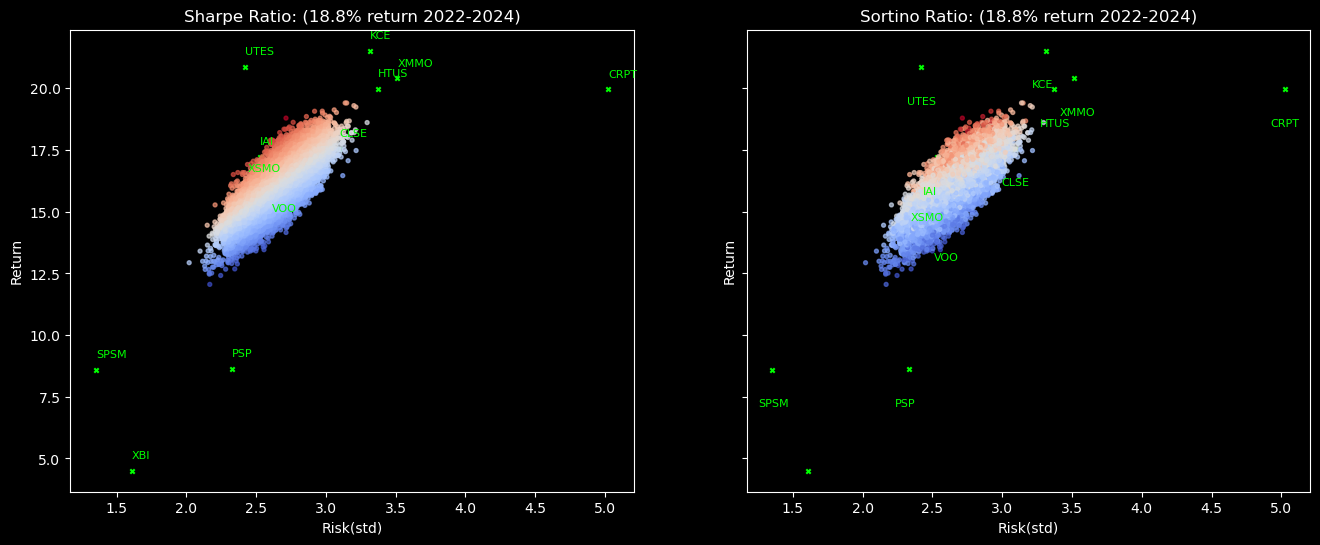

In [11]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
axes[0].scatter(summary.loc[:, "Risk"], summary.loc[:, "Return"]*100, s=10, marker="x", c="lime")
axes[0].scatter(port_summary.loc[:, "Risk"], port_summary.loc[:, "Return"]*100, s=8, c=port_summary.loc[:, "Sharpe"], cmap="coolwarm",
    vmin=port_summary.Sharpe.min(), vmax=port_summary.loc[msrp].Sharpe, alpha=.7)
for i in summary.index:
    axes[0].annotate(i, xy=(summary.loc[i, "Risk"]+0.0002, summary.loc[i, "Return"]*100+.5), size=8, c="lime")

axes[1].scatter(summary.loc[:, "Risk"], summary.loc[:, "Return"]*100, s=10, marker="x", c="lime")
axes[1].scatter(port_summary.loc[:, "Risk"], port_summary.loc[:, "Return"]*100, s=8, c=port_summary.loc[:, "Sortino"], cmap="coolwarm",
    vmin=port_summary.Sortino.min(), vmax=port_summary.loc[msrp1].Sortino, alpha=.7)
for i in summary.index:
    axes[1].annotate(i, xy=(summary.loc[i, "Risk"]-0.1, summary.loc[i, "Return"]*100-1.5), size=8, c="lime")

axes[0].set_xlabel('Risk(std)')
axes[0].set_ylabel('Return')
axes[1].set_xlabel('Risk(std)')
axes[1].set_ylabel('Return')

axes[0].set_title(f"Sharpe Ratio: ({port_summary.loc[msrp].Return*100:.1f}% return {str(start)[:4]}-{end[:4]})")
axes[1].set_title(f"Sortino Ratio: ({port_summary.loc[msrp1].Return*100:.1f}% return {str(start)[:4]}-{end[:4]})")
plt.show()

In [12]:
# Today's liquidation
s0 = 0
for v in range(100):
    ploc = int(v*(prices.shape[0]/100))
    df = (prices/prices.iloc[ploc]).dropna()
    df['Sharpe'], df['Sortino'] = (df.iloc[:,:len(msrp_w)] * msrp_w).sum(axis=1), (df.iloc[:,:len(msrp1_w)] * msrp1_w).sum(axis=1)
    ratios = (ann_risk_return(df.iloc[ploc:,-2:])['Return']*100)[-2:].values
    s0 = s0 + 1 if ratios[0] > ratios[1] else s0 -1
model = 'Sharpe' if s0 > 0 else 'Sortino'
print(f"{abs(s0)}% of samples in favor of {model}")

100% of samples in favor of Sortino


In [13]:
# Range of liquidations, start prices
s0 = 0
for v in range(99, 0, -1):
    ploc = int(v * (prices.shape[0] / 100))
    if ploc < 2:
        continue
    df = (prices / prices.iloc[0]).dropna()
    df['Sharpe'], df['Sortino'] = (df.iloc[:,:len(msrp_w)] * msrp_w).sum(axis=1), (df.iloc[:,:len(msrp1_w)] * msrp1_w).sum(axis=1)
    ratios = (ann_risk_return(df.iloc[:ploc,-2:])['Return']*100)[-2:].values
    s0 = s0 + 1 if ratios[0] > ratios[1] else s0 -1
model = 'Sharpe' if s0 > 0 else 'Sortino'
print(f"{abs(s0)}% of samples in favor of {model}")

99% of samples in favor of Sortino


In [14]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Price Correlation", "% Change Correlation"))#, "Price Covariance"))
kw = {
    'x':prices.columns,
    'y':prices.columns,
    'colorscale': "Jet",
    'showscale':False,
}
f1 = go.Heatmap(name='Correlation', z=prices.corr(), zmid=0.0, **kw)
f2 = go.Heatmap(name='% Changes Correlation', z=prices.pct_change().corr(), zmid=0.0, **kw)
# f3 = go.Heatmap(name='Price Covariance', z=prices.cov(), zmid=0.0, **kw)

fig.add_trace(f1, row=1, col=1)
fig.add_trace(f2, row=1, col=2)
# fig.add_trace(f3, row=1, col=3)
fig.update_layout(template=template, height=500, width=1000, margin=dict(l=10, r=10, b=10, t=20))
fig.update_yaxes(autorange="reversed")
fig.show()

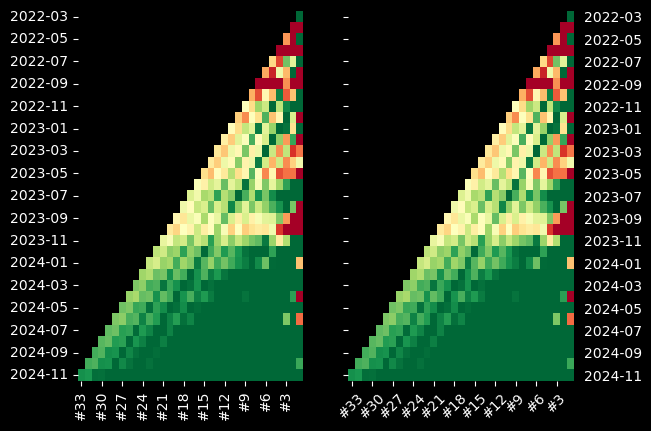

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2)
prices.index = pd.to_datetime(prices.index)
ax={'sharpe': ax1, 'sortino': ax2}
for i, v in ax.items():
    p_tr = prices[i].resample("ME").last()
    p_ret = np.log(p_tr / p_tr.shift()).dropna().to_frame()
    p_ret.columns = ["Return"]
    windows = [year for year in range(p_ret.index.size, 0, -1)]
    for period in windows:
        p_ret["#{}".format(period)] = p_ret.Return.rolling(period).mean()
    triangle = p_ret.drop(columns = ["Return"])
    triangle.index = triangle.index.to_period('M')
    sns.heatmap(triangle, annot=False, cmap="RdYlGn", vmin=-0.2/12, vmax=0.2/12, center=0, cbar=False, ax=v)

# plt.figure(figsize=(80,50))
plt.tick_params(axis = "y", labelright =True, labelleft=False, grid_alpha=.5)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [16]:
v=0
log=True
df = (prices/prices.iloc[int(v*(prices.shape[0]/100))]).dropna()
ar = ann_risk_return(df.iloc[int(v*(prices.shape[0]/100)):])
layout = dict(
    title="Normalized Returns since {}. Sharpe: {:.1f}%. Sortino: {:.1f}%. Max: {:.1f} ({})".format(
        str(prices.iloc[int(v*(prices.shape[0]/100))].name)[:10],
        ar.iloc[-2]['Return']*100,
        ar.iloc[-1]['Return']*100,
        ar.Return.iloc[ar.Return.argmax()]*100,
        ar.iloc[ar.Return.argmax()].name
    ),
    log_y=True,
    template=template
)
px.line(df, **layout)

## Pricing ##

In [17]:
fig = go.Figure()
fig.add_trace(go.Bar(x=summary.index, y=summary['SystRisk'], name='SystRisk'))
fig.add_trace(go.Bar(x=summary.index, y=summary['UnsystRisk'], name='UnsystRisk'))
fig.update_layout({
    # 'barmode': 'stack',
    'title': "Risks",
    'template': template,
    'yaxis': {'title_text': "Risk"}
})
fig

In [18]:
options = ['alpha', 'beta', 'Risk', 'SystRisk', 'UnsystRisk', 'TotalRisk', 'Sharpe', 'capm_ret']
slider = widgets.IntSlider(min=1, max=len(options))
def print_val(v):
    titles = (f"Sharpe Portfolio Components Return vs {options[v-1]}: {port_summary.loc[msrp].Return*100:.1f}% {start.strftime('%Y')}-{end[:4]}",
            f"Sortino Portfolio Components Return vs {options[v-1]}: {port_summary.loc[msrp1].Return*100:.1f}% {start.strftime('%Y')}-{end[:4]}")
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, shared_yaxes=True, subplot_titles=titles)
    kw = {
        'hovertext': summary.index,
        'x':summary[options[v-1]],
        'y':summary['Return'],
        'mode':'markers',
        'marker':dict(size=summary['weight']+1, color=pd.factorize(summary['category'])[0]),
        'showlegend': False,
    }
    kw1 = {
        'hovertext': summary.index,
        'x':summary[options[v-1]],
        'y':summary['Return'],
        'mode':'markers',
        'marker':dict(size=summary['weight1']+1, color=pd.factorize(summary['category'])[0]),
        'showlegend': False,
    }
    f1 = go.Scatter(**kw)
    f2 = go.Scatter(**kw1)
    
    fig.add_trace(f1, row=1, col=1)
    fig.add_trace(f2, row=2, col=1)
    fig.update_layout(template=template, height=500, width=1000, margin=dict(l=10, r=10, b=10, t=30))
    return fig

interact(print_val,v=slider);

interactive(children=(IntSlider(value=1, description='v', max=8, min=1), Output()), _dom_classes=('widget-inte…

## Sectors ##

In [19]:
# Sector coverage in funds
for i in range(summary.shape[0]):
    try: # fund_sector_weightings fails for certain funds, need to find one that succeeds
        if not any(tickers[summary.index[i]].fund_sector_weightings):
            continue
    except:
        continue
    break
snames = tickers[summary.index[i]].fund_sector_weightings.index
sectors=pd.DataFrame([
    funds[fund]["topHoldings"]['sectorWeightings'] if funds[fund].get("topHoldings",{}).get('sectorWeightings') else len(snames) * [None]
    for fund in funds
], index=summary.index, columns=snames).replace(to_replace=[None], value=[dict({'none': 0.0})])
for c in sectors.columns:
    sectors[c] = [v for d in sectors[c].values for v in d.values()]
sectors = sectors.T
sectors['sharpe']=(sectors * msrp_w).sum(axis=1)
sectors['sortino']=(sectors * msrp1_w).sum(axis=1)
sectors.sort_index(inplace=True)
px.imshow(sectors*100, template=template, title='Top Sectors')

## Overlaps ##

In [20]:
g = net.Network(notebook=True, bgcolor='#111111', font_color='white', width="100%", height="800px")#, cdn_resources='in_line')
# g.repulsion()
g.physics = "forceAtlas2Based"
# g.inherit_edge_colors(False)
nxg=nx.complete_graph(0)
for n in summary.index: # FIXME: colors of edges
    kw = {'label':n, 'shape':'box'} #'size':abs(summary.loc[n, 'Return'])*100
    kw['title'] = textwrap.fill(funds[n]['summaryProfile'].get('longBusinessSummary', funds[n]['summaryProfile'].get('description')), 60)
    if summary.loc[n, 'Return'] < 0:
        kw['color'] = 'red'
    kw['borderWidth'] = abs(summary.loc[n]['Return']) * 100
    kw['group'] = summary.loc[n]['category']
    nxg.add_node(n, **kw)
    for h in funds[n].get('topHoldings',{}).get('holdings',{}):
        nxg.add_node(h['symbol'], label=h['holdingName'], shape='text')
        nxg.add_edge(n, h['symbol'], value=h['holdingPercent'], title=f"{100*h['holdingPercent']:.1f}%")
g.from_nx(nxg)
g.show("overlaps.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### Obsolete

In [21]:
ms = range(20, 101, 10)
dfmd = pd.DataFrame(index = ms, columns=idx['Adj Close'].columns)

for finish in ms:
    n, best = min([3, len(idx['Adj Close'].columns)//2]), {c:0 for c in idx['Adj Close'].columns}
    for v in range(100):
        t0 = int(v * (prices.shape[0] * finish / 100 / 100)) # Starting time for comparison
        df = (prices.iloc[:int((prices.shape[0] * finish / 100))] / prices.iloc[t0]).dropna() # DataFrame normalized against Starting time prices
        if t0 + 1 >= df.shape[0]:
            continue
        ratios = ann_risk_return(df.iloc[int(v * (df.shape[0] / 100)):])['Return'][:-2] * 100
        for x in ratios.nlargest(n).index:
            best[x] = 1 if not x in best else best[x]+1
    summary['Top'] = [best[x] for x in sorted(best)] # Sample 100 intervals' to date for top N returns
    weight = 'weight' if model == 'Sharpe' else 'weight1'
    dfmd.loc[finish] = [best[x] for x in sorted(best)]
    
dfmd.index = [str(prices.iloc[int(prices.shape[0] * x / 100)].name)[:10] for x in range(10, 100, 10)]
px.imshow(dfmd.T, template=template, color_continuous_scale=px.colors.sequential.Viridis, color_continuous_midpoint=55,
          title=f"In Top {n} Performers {dfmd.index[0]} ... {dfmd.index[-1]}")

## Correlations ##

---

## Screener

In [22]:
droplist = " ".join((TEST, " ".join((categories.values()))))
shortlist = []
for r in recommendations.values():
    for v in r.values():
        if v=='No data found':
            continue
        for rec in v['recommendedSymbols']:
            if not (rec['symbol'] in droplist):
                shortlist.append(rec['symbol'])
profiles = {n:Ticker(n).fund_profile[n] for n in shortlist}
for prop in ['maxAge', 'styleBoxUrl']:
    for k,v in profiles.items():
        if prop in v:
            del v[prop]
shortlist = [p for p, v in profiles.items() if 'categoryName' in v and not 'Leveraged' in v['categoryName']]
" ".join(sorted({*shortlist}))

'BITQ BKCH CBLS CTA DAPP FDIG FTLS FUTY FXU HAWX HFXI HSCZ IAK IAT IBB IHF IYG JHMU KBE KIE LBAY PBP PDP PEX PSCU PUI PWV SATO SLYV SPDW SPEM SPGP SPMD SPMO SPTM VAMO XLF XLI XLK XLV XMHQ XMVM XSVM'

In [23]:
# Recommendations
g = net.Network(notebook=True, bgcolor='#111111', font_color='white', width="100%", height="800px")#, cdn_resources='in_line')
g.repulsion()
g.physics = "forceAtlas2Based"
nxg=nx.complete_graph(0)
for n in summary.index:
    kw = {'label':n, 'shape':'box'}
    kw['group'] = summary.loc[n]['category']
    kw['title'] = textwrap.fill(funds[n]['summaryProfile'].get('longBusinessSummary', funds[n]['summaryProfile'].get('description')), 60)
    nxg.add_node(n, **kw)
    if list(recommendations[n].values()) == ['No data found']:
        continue
    for h in list(recommendations[n].values())[0]['recommendedSymbols']:
        if not h['symbol'] in shortlist:
            continue
        nxg.add_node(h['symbol'], label=h['symbol'], shape='text', title=json.dumps(profiles[h['symbol']], indent=2))
        nxg.add_edge(n, h['symbol'], value=h['score'], title=100*h['score'])
g.from_nx(nxg)
g.show("recommendations.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [24]:
s = Screener()
print([x for x in s.available_screeners if 'etf' in x and not 'asia' in x and not 'europe' in x])

['best_hist_performance_etfs', 'bond_etfs', 'cheapest_etfs', 'commodity_etfs', 'day_gainers_etfs', 'day_losers_etfs', 'fifty_two_wk_gainers_etfs', 'fifty_two_wk_losers_etfs', 'high_growth_large_etfs', 'large_blend_etfs', 'most_actives_etfs', 'precious_metal_etfs', 'sp_500_etfs', 'technology_etfs', 'top_etfs', 'top_etfs_hk', 'top_etfs_in', 'top_etfs_us', 'top_performing_etfs']


In [25]:
screener = ['fifty_two_wk_losers_etfs', 'cheapest_etfs', 'top_etfs_us'] #'top_performing_etfs', 'precious_metal_etfs'
def g(row):
    return [str(r) for r in row.values]
    
def bold_row(row):
    return ['font-weight: bold' if 'ChangePercent' in row.name else '' for v in row]

def bold_index(s):
    return '<b>{}</b>'.format(s)

def h_hi(row):
    return ['background-color: lightgreen']*len(row.values) if 'ChangePercent' in row.name else ['']*len(row.values)

droprows=["shortName", 'exchange', 'firstTradeDateMilliseconds', 'messageBoardId', 'dividendDate', 'fiftyTwoWeekLowChangePercent',
          'fiftyTwoWeekHighChangePercent', 'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent', 'fiftyTwoWeekLowChange',
          'fiftyTwoWeekHighChange', 'regularMarketChange', 'isEarningsDateEstimate', 'postMarketChangePercent', 'askSize', 'bidSize',
          'ipoExpectedDate', 'epsTrailingTwelveMonths', 'sharesOutstanding', 'bookValue', 'marketCap', 'netAssets']
quotes = [i for q in s.get_screeners(screener, 48).values() for i in q['quotes'] if not i['symbol'] in droplist]
df = pd.json_normalize(quotes).set_index('symbol').T
df.drop(df.index[:7], inplace=True)
df.drop([c for c in df.index if 'Time' in c], inplace=True)
df.dropna(axis=1, subset=['longName'], inplace=True)

regex = re.compile('|'.join(['everage', "Ether", 'Bitcoin', 'Bond', "Ultra", "Short", "Long", 'Hedge', 'Option', 'Covered Call', 'Treasury',
                             "Trust", "Daily", "Monthly", 'Weekly', 'Asia', 'China', 'Emerging', 'iShares MSCI']))
df.drop(columns=df.columns[df.loc['longName'].str.contains(regex)], axis=1, inplace=True)

for i in df.index:
    if 1 == len(set(g(df.loc[i,:]))):
        droprows.append(i)
df.drop(droprows, inplace=True, errors='ignore')
df = df.sort_values(by=['fiftyTwoWeekChangePercent'], axis=1, ascending=False)
df = df.fillna('')

df.drop(droplist, axis=1, errors='ignore', inplace=True)
df.head(60).style.apply(h_max, axis=1).apply(h_min, axis=1).apply(bold_row, axis=1).apply(h_hi, axis=1)

symbol,BLOK,AMNA,ATMP,GCAD,DWLD,REZ,BKLC,SCHX,USPX,BBUS,SPMD,SPTM,SPLG,IVV,BBP,LOPP,RSPR,DINT,COWS,USRT,BBRE,GOEX,COPX,XLRE,REET,PFFA,FHLC,IGRO,XLV,GXG,MFDX,YYY,INEQ,IEFA,IDHQ,QEFA,HDEF,GCOW,DJCB,SMBS,EUDG,UDN,WEED
postMarketPrice,48.200000,,,,,88.000000,,23.860000,,108.460000,59.120000,73.330000,70.435000,601.775000,67.120000,,38.110000,,,61.430000,,,41.908000,45.260000,,22.531000,69.170000,,146.960000,,,12.090000,,72.580000,,,25.010000,,,,,18.030000,
postMarketChange,-1.460000,,,,,-1.769997,,0.080000,,0.000000,0.059998,-0.004997,-0.005005,-0.044983,1.610000,,-0.669998,,,-1.318000,,,-0.271999,0.049999,,-0.073999,-0.794998,,0.010010,,,-0.014999,,0.000000,,,0.000000,,,,,0.000000,
regularMarketPrice,49.660000,55.811800,30.094800,35.737800,38.654000,89.770000,114.460000,23.780000,52.614500,108.460000,59.060000,73.330000,70.440000,601.820000,65.855700,29.857600,38.780000,23.528600,31.674100,62.760000,102.860000,32.154200,42.180000,45.210000,26.420000,22.620000,70.030000,70.520000,146.950000,24.040000,30.470900,12.105000,30.130400,72.580000,29.370000,75.220000,25.010000,35.190000,20.380800,25.355000,30.675500,18.030000,19.854900
regularMarketDayHigh,49.820000,55.811800,30.190000,35.737800,38.879900,90.475000,114.900000,23.860000,52.770000,108.810000,59.799800,73.638100,70.679900,603.788900,65.855700,29.857600,38.937000,23.610000,31.815000,63.210000,103.370400,32.319700,42.600000,45.482100,26.530000,22.639900,70.292500,70.640000,147.755200,24.050500,30.471800,12.130000,30.130400,72.730000,29.370000,75.310000,25.040000,35.270000,20.380800,25.360000,30.675500,18.030000,19.854900
regularMarketDayRange,48.5799 - 49.82,55.8118 - 55.8118,29.9 - 30.19,35.6801 - 35.7378,38.6481 - 38.8799,89.75 - 90.475,114.3 - 114.9,23.71 - 23.86,52.54 - 52.77,108.26 - 108.81,58.97 - 59.7998,73.18 - 73.6381,70.26 - 70.6799,600.26 - 603.7889,65.8557 - 65.8557,29.8576 - 29.8576,38.75 - 38.937,23.4007 - 23.61,31.6741 - 31.815,62.66 - 63.21,102.8603 - 103.3704,32.1542 - 32.3197,41.99 - 42.6,45.11 - 45.4821,26.4043 - 26.53,22.52 - 22.6399,69.9 - 70.2925,70.27 - 70.64,146.31 - 147.7552,23.785 - 24.0505,30.42 - 30.4718,12.04 - 12.13,30.1304 - 30.1304,72.375 - 72.73,29.1722 - 29.37,74.93 - 75.31,24.8874 - 25.04,35.06 - 35.27,20.3808 - 20.3808,25.3081 - 25.36,30.615 - 30.6755,17.9398 - 18.03,19.8549 - 19.8549
regularMarketDayLow,48.579900,55.811800,29.900000,35.680100,38.648100,89.750000,114.300000,23.710000,52.540000,108.260000,58.970000,73.180000,70.260000,600.260000,65.855700,29.857600,38.750000,23.400700,31.674100,62.660000,102.860300,32.154200,41.990000,45.110000,26.404300,22.520000,69.900000,70.270000,146.310000,23.785000,30.420000,12.040000,30.130400,72.375000,29.172200,74.930000,24.887400,35.060000,20.380800,25.308100,30.615000,17.939800,19.854900
regularMarketVolume,390062,50,10571,811,9398,51243,87827,2996812,1512286,186385,689560,517429,4358408,2486779,994,95,8104,181621,8970,148174,6073,1086,1281525,3529988,1182192,329692,149157,39617,5629235,14170,15799,228998,821,11925447,49760,37379,234379,186745,105,6388,8162,198655,4954
regularMarketPreviousClose,48.290000,55.345300,29.840000,36.001800,38.367800,89.280000,114.960000,23.850000,52.831200,108.860000,59.230000,73.580000,70.670000,603.760000,64.485700,29.832900,38.471700,23.104800,31.710900,62.320000,102.175000,31.710000,41.860000,44.900000,26.190000,22.500000,69.560000,70.090000,146.170000,23.860100,30.280400,12.040500,30.063300,72.200000,29.090000,74.799100,24.840000,34.980000,20.805100,25.272900,30.439600,17.840000,19.137400
bid,49.660000,27.930000,15.060000,17.890000,35.000000,87.960000,114.510000,23.700000,49.710000,108.170000,59.040000,71.850000,70.380000,601.580000,65.680000,14.960000,36.480000,20.900000,23.010000,61.430000,97.200000,29.120000,42.130000,44.850000,26.220000,22.530000,69.000000,66.620000,146.960000,23.280000,27.740000,12.100000,29.990000,72.340000,26.470000,71.020000,23.280000,34.000000,19.000000,23.930000,30.610000,17.980000,18.500000
ask,49.690000,83.790000,45.160000,53.670000,58.

In [26]:
" ".join(df.columns)

'BLOK AMNA ATMP GCAD DWLD REZ BKLC SCHX USPX BBUS SPMD SPTM SPLG IVV BBP LOPP RSPR DINT COWS USRT BBRE GOEX COPX XLRE REET PFFA FHLC IGRO XLV GXG MFDX YYY INEQ IEFA IDHQ QEFA HDEF GCOW DJCB SMBS EUDG UDN WEED'

## Algo Return

In [27]:
algo=(1 + idx['Adj Close'].pct_change() * idx['position_ema'].shift(1)).cumprod()
px.line(algo, template=template, log_y=True, title="Algo EMA")

In [28]:
algo=(1 + idx['Adj Close'].pct_change() * idx['position_rsi'].shift(1)).cumprod()
px.line(algo, template=template, log_y=True, title="Algo RSI")

In [29]:
# def calc_positions_ichimoku(d):
#     global idx
#     columns = d['Low'].columns
#     condition = np.where(
#         # (d['Close'] > d['tenkan_sen']) & (d['tenkan_sen'] > d['kijun_sen']) &
#         ((d['Close'] > d['tenkan_sen']) & (d['Close'] > d['kijun_sen'])) & (d['tenkan_sen'] > d['kijun_sen']) &
#         (
#             ((d['Close'] > d['senkou_span_a']) & (d['Close'] > d['senkou_span_b'])) |
#             ((d['Close'] < d['senkou_span_a']) & (d['Close'] < d['senkou_span_b']) & (d['senkou_span_a'] < d['senkou_span_b']))
#         ), 0, 1
#     )
#     sgn = pd.DataFrame(condition, columns=columns, index=d.index)
#     sgn.columns = pd.MultiIndex.from_product([['signal_ichimoku'], columns])
#     pos = sgn.diff().fillna(0)
#     pos.columns = pd.MultiIndex.from_product([['position_ichimoku'], columns])
#     idx.drop(columns='signal_ichimoku', inplace=True, errors='ignore')
#     idx.drop(columns='position_ichimoku', inplace=True, errors='ignore')
#     idx = idx.join(pos)
#     idx = idx.join(sgn)
# calc_positions_ichimoku(idx)

algo=(1 + idx['Adj Close'].pct_change() * idx['position_ichimoku'].shift(1)).cumprod()
px.line(algo, template=template, log_y=True, title="Algo Ichimoku")

## Timestamp

In [30]:
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2024-11-27 21:59:52'